In [110]:
from file_parser import *
import matplotlib.pyplot as plt
import numpy as np

In [111]:
input = reads('../CCS_StartFiles/Assignment_2/data/input.pcm')/(2**15)
output = reads('../CCS_StartFiles/Assignment_2/data/output.pcm')/(2**14)

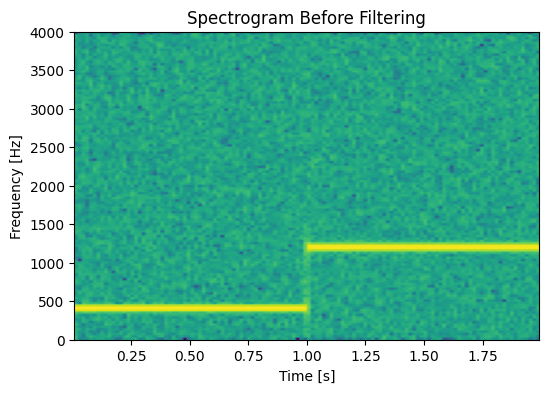

In [112]:
plt.figure(figsize=(6,4))
plt.specgram(input, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram Before Filtering")
plt.show()

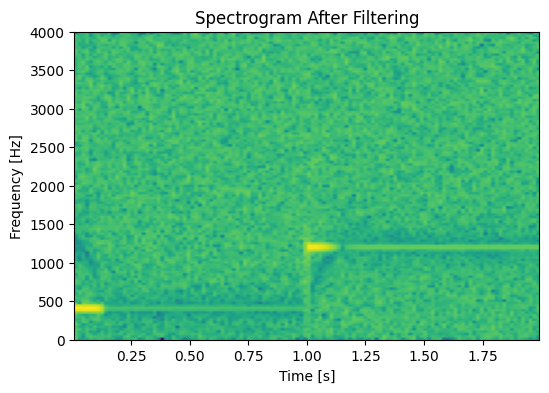

In [113]:
plt.figure(figsize=(6,4))
plt.specgram(output, Fs=8000)
#plt.specgram(sinesweep, Fs=fs)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram After Filtering")
plt.show()

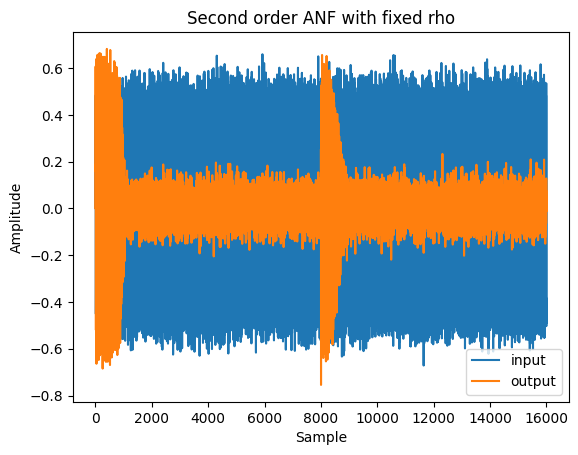

In [114]:
plt.figure()
plt.plot(input)
plt.plot(output)
plt.title('Second order ANF with fixed rho')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(['input', 'output'])